In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv # for excel too 
import json 
import random
import numpy as np
import itertools 
import matplotlib as mpl
import sys
import os
import copy 
import pickle 
# import scipy

# for natural language processing 
import nltk
from nltk.stem.porter import *
# nltk.download("stopwords")
# nltk.download("averaged_perceptron_tagger")

from sklearn.preprocessing import StandardScaler 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import mixture, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # similar to Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix, \
    classification_report, accuracy_score 
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.covariance import empirical_covariance

# import word embeddings models 
from transformers import BertTokenizer, BertModel
import torch

# LSTM and CNN *** sharfard paper 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import LSTM

from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# Remove all the un-necessary warnings
# import warnings
# warnings.filterwarnings('ignore')
conan_path = 'CONAN-master/Multitarget-CONAN/'
conan_file = 'Multitarget-CONAN.json'
conan_p = conan_path + conan_file

davidson_path = 'hate-speech-and-offensive-language-master/data/'
davidson_f = 'labeled_data.csv' 
davidson_p = davidson_path + davidson_f

combined_path = ''
combined_f = 'combined_dataset.csv'
combined_p = combined_path + combined_f

reports_path = 'classification_reports/'
data_path = 'datasets/'
model_path = 'models/'

In [3]:
class Classifier:
    def __init__(self, labels, *args, **kwargs): # X, y, **kwargs):   
        # second_capital = re.search('^([^A-Z]*[A-Z]){2}', kwargs.)
        self.labels = labels # kwargs.pop('labels', '') # args[1] 
        
        name_regex = '([a-zA-Z]*)(\s*)([a-zA-Z]*)'
        clsf = kwargs.pop('classifier', '')
        normalize = lambda name: (name.group(1).strip().capitalize() + " " + name.group(3).strip().capitalize())
        # print(re.match(name_regex, clsf).group(1).strip().capitalize())
        # print(re.match(name_regex, clsf).group(3).strip().capitalize())
        self.model_name = re.sub(name_regex, normalize, clsf).strip() # or re.sub(name_regex, normalize, kwargs.pop('model', ''))
        # print(clsf)
        self.model = LogisticRegression(random_state = 0) if self.model_name == "Logistic Regression" else \
            RandomForestClassifier(random_state = 0) if self.model_name == "Random Forest" else \
            GaussianNB() if self.model_name == "Naive Bayes" else \
            DecisionTreeClassifier(random_state = 0) if self.model_name == "Decision Trees" else \
            XGBoostClassifier(random_state = 0) if self.model_name == "XGBoost" else \
            SVC(random_state = 0) # if self.model_name == "SVM" else None
        if self.model is None:
            self.model = kwargs.get('model', None) # if self.model_name == "SVM" else None
        self.model_params = kwargs.get('model_params', None) # == 'model_params'
        self.CV = kwargs.get('cv', None) # == 'cv'
        self.cv_params = kwargs.get('cv_params', None) # == 'cv_params'
        # print(self.model_params)
        # print(self.CV)
        # print(self.cv_params)
        self.preds = None
        self.cls_report = None 
        self.acc_report = None 
        self.train_score = None
        self.test_score = None 
        self.conf_m = None 
        self.filename = (self.model_name.lower().replace(" ", "_")) 
        # print(param_grid)
        # print("args:", args)
        # print("kwargs:", kwargs)
        # print("cv params:", self.cv_params)
        if self.CV is not None: 
            self.cross_validation(*args, **kwargs) #model = self.model, model_params = self.model_params, 
                              # cv = self.CV, cv_params = self.cv_params)
      
    def cross_validation(self, *args, **kwargs): 
        model = self.model if self.model is not None else kwargs.pop('model', None)
        model_params = self.model_params if self.model_params is not None else kwargs.pop('model_params', None)
        cv = self.CV if self.CV is not None else kwargs.pop('cv', None)
        cv_params = self.cv_params if self.cv_params is not None else kwargs.pop('cv_params', None)
        print("cross_validation")
        # print(model)
        print("args", args)
        print("kwargs:", kwargs)
        print("cv params:", cv_params)
        # print(param_grid)
        args = [cv_params[0]] 
        default_args = cv_params[1] # [1:] 
        print("param_grid:", param_grid)
        print("cv params:", cv_params)
        print("args", args)
        print("default_args", default_args)
        self.model = cv(model, *args, **default_args) # *args, **default_args) # create cross validator model 
        # self.model = cv(model, args, kwargs, *cv_params) # args, kwargs, *cv_params)
        # self.CV = cv(model, args, kwargs) if (model_params and cv_params) is None else cv(model(*model_params), args, kwargs) if cv_params is None else \
        #     cv(model, args, kwargs, *cv_params) if model_params is None else cv(model(*model_params), args, kwargs, *cv_params)  # GridSearch()
        return self.model 
    
    def set_params(self, *args, **kwargs):
        self.labels = kwargs.pop('labels', '')# should be labels 
        
        name_regex = '([a-zA-Z]*)(\s*)([a-zA-Z]*)'
        clsf = kwargs.pop('classifier', '')
        normalize = lambda name: (name.group(1).strip().capitalize() + " " + name.group(3).strip().capitalize())
        self.model_name = re.sub(name_regex, normalize, clsf).strip() # or re.sub(name_regex, normalize, kwargs.pop('model', ''))
        self.model = LogisticRegression(random_state = 0) if self.model_name == "Logistic Regression" else \
            RandomForestClassifier(random_state = 0) if self.model_name == "Random Forest" else \
            GaussianNB() if self.model_name == "Naive Bayes" else \
            DecisionTreeClassifier(random_state = 0) if self.model_name == "Decision Trees" else \
            XGBoostClassifier(random_state = 0) if self.model_name == "XGBoost" else \
            SVC(random_state = 0) 
        if self.model is None:
            self.model = kwargs.pop('model', None) # if self.model_name == "SVM" else None
        self.model_params = kwargs.pop('model_params', None) # == 'model_params'
        self.CV = kwargs.pop('cv', None) # == 'cv'
        self.cv_params = kwargs.pop('cv_params', None) # == 'cv_params'
        
        self.preds = kwargs.pop('preds', None)
        self.cls_report = kwargs.pop('cls_report', None) 
        self.acc_report = kwargs.pop('acc_report', None)
        self.conf_m = None 
        self.filename = (self.model_name.lower().replace(" ", "_")) 
        
    def set_model_params(self, *args, **kwargs): 
        self.model = LogisticRegression(args, kwargs, random_state = 0) if (self.model_name == "Logistic Regression") else \
            RandomForestClassifier(args, kwargs, random_state = 0) if (self.model_name == "Random Forest") else \
            GaussianNB(args, kwargs) if self.model_name == "Naive Bayes" else \
            DecisionTreeClassifier(args, kwargs, random_state = 0) if self.model_name == "Decision Trees" else \
            XGBoostClassifier(args, kwargs, random_state = 0) if self.model_name == "XGBoost" else \
            SVC(args, kwargs, random_state = 0) # if self.model_name == "SVM" else None
        if self.model is None:
            self.model = (kwargs.pop('model', None))(args, kwargs) # if self.model_name == "SVM" else None
  
    def get_model(self): # return current model instance 
        return self.model
    
    def load(self, infile = "", path = ""): 
        if infile is "": 
            with open(path + self.filename + ".pkl", "rb") as file: # read byte 
                self = pickle.load(file)
        else: 
            with open(infile, "rb") as file: # read byte 
                self = pickle.load(file)
        return self # Classifier(labels, model) 
    
    def load_model(self, infile = "", path = ""): 
        if infile is "": 
            with open(path + self.filename + "_model.pkl", "rb") as file: # read byte 
                self.model = pickle.load(file)
        else: 
            with open(infile, "rb") as file: # read byte 
                self.model = pickle.load(file)
        return self.model # Classifier(labels, model) 
    
    def save(self, path = "", outfile = ""):
        if outfile is "": 
            with open(path + self.filename + ".pkl", "wb") as file: # write byte 
                pickle.dump(self, file)
        else: 
            with open(outfile, "wb") as file: # write byte 
                pickle.dump(self, file)
        return self 
    
    def save_model(self, path = "", outfile = ""):
        if outfile is "": 
            with open(path + self.filename + "_model.pkl", "wb") as file: # write byte 
                pickle.dump(self.model, file)
        else: 
            with open(outfile, "wb") as file: # write byte 
                pickle.dump(self.model, file)
        return self.model 
        
    def fit(self, X_train, y_train):  # returns model object as well 
        self.model.fit(X_train, y_train)
        return self.model 
        
    def predict(self, X_test): 
        self.preds = self.model.predict(X_test)
        return self.preds
    
    def report_results(self, y_test = None, preds = None, output = True, save = False, path = "", outfile = ""): 
        cls_report = self.cls_report if (y_test is None) and (preds is None) else self.classification_report(y_test, preds, output = False) 
        acc_report = self.acc_report if (y_test is None) and (preds is None) else self.accuracy_score(y_test, preds, output = False)
        conf_m = np.array_str(self.conf_m, precision = 3) if (y_test is None) and (preds is None) \
        else np.array_str(self.confusion_matrix(y_test, preds, output = False), precision = 3) 
    
        report = cls_report + "\n" + acc_report + "\n" + conf_m

        if save: 
            if outfile is "": 
                # report.to_csv(path + self.filename + "_results.csv", sep = ",", index = False, encoding = 'utf8')
                with open(path + self.filename + "_results.txt", "w+", encoding = "utf8") as file: # write byte 
                    file.write(report)
            else: 
                # report.to_csv(outfile, sep = ",", index = False, encoding = 'utf8')
                with open(outfile, "w+", encoding = "utf8") as file: # write byte 
                    file.write(report)
    
    def classification_report(self, y_test, preds, output = True, save = False, path = "", outfile = ""): 
        self.cls_report = classification_report(y_test, preds)
        if output: 
            print(self.cls_report)
        if save: 
            report = classification_report(y_test, preds, output_dict = save)
            report = pd.DataFrame(report).transpose()
            if outfile is "": 
                report.to_csv(path + self.filename + "_clsf_report.csv", sep = ",", index = False, encoding = 'utf8')
                # with open(path + self.filename + ".csv", encoding = "utf8") as file: # write byte 
                    # file.write(report)
            else: 
                report.to_csv(outfile, sep = ",", index = False, encoding = 'utf8')
                # with open(outfile, encoding = "utf8") as file: # write byte 
                    # file.write(report) 
        return self.cls_report 
            
    def accuracy_score(self, y_test, preds, output = True, save = False, path = "", outfile = ""): 
        self.train_score = self.model.score(X_train, y_train)
        self.test_score = accuracy_score(y_test, preds)
        report = '{} Train accuracy {:.3f}%'.format(self.model_name, self.train_score * 100) + '\n' \
            + '{} Test accuracy {:.3f}%'.format(self.model_name, self.test_score * 100) + '\n'
        self.acc_report = report 
        if output: 
            print(report) 
        if save: 
            if outfile is "": 
                # report.to_csv(path + self.filename + "acc_report.csv", sep = ",", index = False, encoding = 'utf8')
                with open(path + self.filename + "_acc_report.txt", "w+", encoding = "utf8") as file: # write byte 
                    file.write(report)
            else: 
                # report.to_csv(outfile, sep = ",", index = False, encoding = 'utf8')
                with open(outfile, "w+", encoding = "utf8") as file: # write byte 
                    file.write(report) 
        return self.acc_report   
        
    def confusion_matrix(self, y_test, preds, output = True, save = False, path = "", outfile = ""): 
        self.conf_m = confusion_matrix(y_test, preds)
        if output:  
            print('Confusion matrix: ')
            print(self.conf_m)
        
        if save: 
            if outfile is "": 
                # report.to_csv(path + self.filename + "conf_matrix.csv", sep = ",", index = False, encoding = 'utf8')
                with open(path + self.filename + "_conf_matrix.txt", "w+", encoding = "utf8") as file: # write byte 
                    file.write(str(self.conf_m))
            else: 
                # report.to_csv(outfile, sep = ",", index = False, encoding = 'utf8')
                with open(outfile, "w+", encoding = "utf8") as file: # write byte 
                    file.write(str(self.conf_m)) 
        return self.conf_m
    
    def heatmap(self, conf_m = None, labels = None, save = False, path = "", outfile = ""):  # draw confusion matrix 
        conf_m = self.conf_m if conf_m is None else conf_m 
        labels = self.labels if labels is None else labels 
        
        size = len(conf_m)
        matrix = np.zeros((size, size))
        for i in range(0, size):
            matrix[i, :] = (conf_m[i, :])/(float(conf_m[i,:].sum()))
            
        conf_df = pd.DataFrame(matrix, index = labels, columns = labels)
        plt.figure(figsize=(size * 1.5, size * 1.25))
        sns.heatmap(conf_df, annot = True, annot_kws = {"size": size * 1.33},
                        cmap='gist_gray_r', cbar = False, square = True, fmt = '.2f')
        plt.ylabel('True categories', fontsize = size * 1.5)
        plt.xlabel('Predicted categories', fontsize = size * 1.5)
        plt.tick_params(labelsize = size * 1.33)

        if save:
            f_name = self.filename + "_heatmap" # "_".join(self.model_name.lower())
            if outfile is "":
                plt.savefig(path + f_name + ".pdf") # '.pdf')
            else: 
                plt.savefig(outfile)

In [4]:
def make_heatmap(conf_m, labels, save = True, out_file = ''): 
    size = len(conf_m)
    matrix = np.zeros((size, size))
    for i in range(0, size):
        matrix[i,:] = conf_m[i,:]/float(conf_m[i,:].sum())
    # labels = ['Hate','Offensive','Neither']
    conf_df = pd.DataFrame(matrix, index=labels, columns = labels)
    
    plt.figure(figsize=(size * 1.5, size * 1.25))
    sns.heatmap(conf_df, annot = True, annot_kws = {"size": 12},
                    cmap='gist_gray_r', cbar = False, square = True, fmt = '.2f')
    plt.ylabel(r'True categories', fontsize=14)
    plt.xlabel(r'Predicted categories', fontsize=14)
    plt.tick_params(labelsize = 12)

    if save:
        plt.savefig(out_file) # '.pdf')

In [5]:
with open(data_path + "combined_data.csv", "r", encoding = "utf8") as file: 
    combined_hate_df = pd.read_csv(file)
    file.close() 
    
with open(data_path + "combined_class.csv", "r", encoding = "utf8") as file: 
    combined_tar_df = pd.read_csv(file)
    file.close() 
    
# display(combined_hate_df)
# display(combined_tar_df)

combined_hate_list = combined_hate_df.iloc[:, 0] 
# display(combined_hate_list) 
# combined_hate_df 
combined_tar_list = combined_tar_df.iloc[:, 0]
# display(combined_tar_list)

0       Maybe the UN could talk to those asian and afr...
1       ‘Juice (Jews) are worse that nukes.’ Caption t...
2       Foreigners on UK benefits leaps 41% in 5 years...
3       Jews cannot be patriots, since their allegianc...
4       Israel, Zionism and Jewish Supremacist control...
                              ...                        
9161    yaya ho.. cute avi tho RT @ViVaLa_Ari I had no...
9162    yea so about @N_tel 's new friend.. all my fri...
9163    you know what they say, the early bird gets th...
9164    you've gone and broke the wrong heart baby, an...
9165    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: HATE_SPEECH, Length: 9166, dtype: object

0       7
1       1
2       3
3       1
4       1
       ..
9161    8
9162    8
9163    8
9164    8
9165    8
Name: CLASS, Length: 9166, dtype: int64

In [7]:
# with open(conan_p, "r", encoding="utf8") as f:
#     multi_target = json.load(f)
# mt_df = pd.DataFrame(multi_target) 

# mt_df = mt_df.T # transpose to make tweets features 
# display(mt_df) 

# # collects target minority into dataframe and series 
# min_tar_orig = mt_df.iloc[:, 2]

min_tar_orig = combined_tar_list
labels = np.unique(min_tar_orig)
labels = np.append(labels, 'none')                 
display(labels)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', 'none'], dtype='<U21')

In [8]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# max and min are cutoffs for document frequency 

# Word Embeddings and Feature Selection 
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                                   max_df = 0.75, min_df=5, 
                                   max_features=10000)
# TF-IDF feature matrix
docs = tfidf_vectorizer.fit_transform(combined_hate_list)
display(docs)

<9166x5733 sparse matrix of type '<class 'numpy.float64'>'
	with 148204 stored elements in Compressed Sparse Row format>

Svm Train accuracy 99.618%
Svm Test accuracy 96.238%

Confusion matrix: 
[[ 39   0   2   0   0   0   0   0   4]
 [  0 132   0   2   0   0   0   1   0]
 [  0   0 109   0   0   0   2   0   7]
 [  0   0   1 183   1   0   1   1   5]
 [  1   0   0   2 267   0   0   1   0]
 [  0   0   1   0   0  58   1   3   2]
 [  0   0   0   0   1   0 129   0   6]
 [  0   0   1   3  11   3   1  32   3]
 [  0   0   0   0   0   0   2   0 816]]


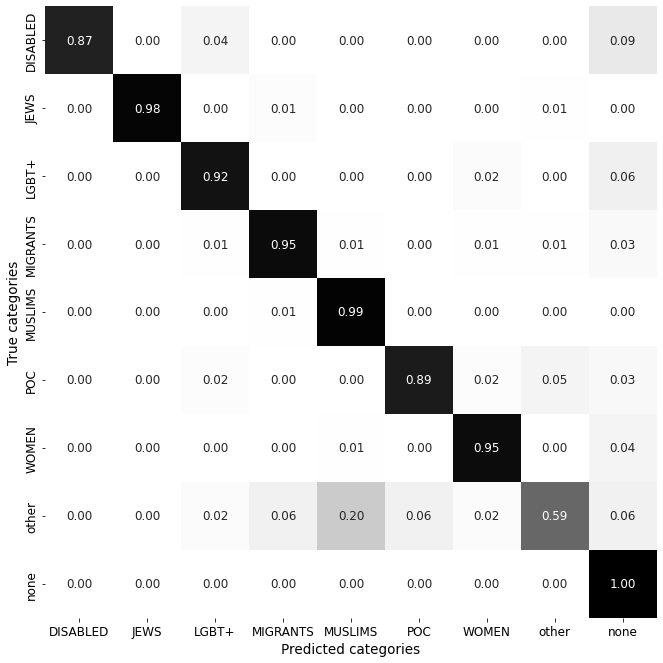

In [518]:
classifiers = ["Logistic Regression", "Random Forest", "Decision Trees", "XGBoost", "SVM", "Naive Bayes"]
# reports_path = 'classification_reports/'
# data_path = 'datasets/'
# model_path = 'models/'

output = True 
save = True 

X = docs
y = combined_tar_list

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

for i in range(range(len(classifiers)): 
    if (classifiers[i] == "Naive Bayes"):
        X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, random_state = 0, test_size = 0.2)
        model = Classifier(labels, classifier = classifiers[i]) 

    elif (classifiers[i] == "SVM"):  # Support Vector Machine 
        param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1 , 0.1, 0.01, 0.001]} 
        model = Classifier(labels, classifier = classifiers[i], cv = GridSearchCV, 
                           cv_params = [param_grid, {'refit': True, 'verbose': 2}]) 
        
    else: 
        model = Classifier(labels, classifier = classifiers[i]) 

    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)

    cls_report = model.classification_report(y_test, y_preds, save = save, path = reports_path)
    acc_report = model.accuracy_score(y_test, y_preds)
    conf_m = model.confusion_matrix(y_test, y_preds, save = save, path = reports_path)

    model.heatmap(save = save, path = reports_path)
    model.report_results(save = save, path = reports_path) 

    model.save_model(path = model_path)
    model.save(path = model_path)

RandomForestClassifier(random_state=0)
RandomForestClassifier(random_state=0)
[8 6 0 ... 3 8 8]
[8 6 0 ... 3 8 8]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        45
           1       0.98      0.94      0.96       135
           2       0.92      0.86      0.89       118
           3       0.94      0.92      0.93       192
           4       0.96      0.97      0.96       271
           5       0.95      0.80      0.87        65
           6       0.95      0.91      0.93       136
           7       0.96      0.44      0.61        54
           8       0.92      1.00      0.96       818

    accuracy                           0.94      1834
   macro avg       0.95      0.85      0.89      1834
weighted avg       0.94      0.94      0.93      1834

Random Forest Train accuracy 99.932%
Random Forest Test accuracy 93.730%

Confusion matrix: 
[[ 37   0   3   0   0   0   0   0   5]
 [  0 127   0   1   0   0   1   0   6]
 [  0   0 

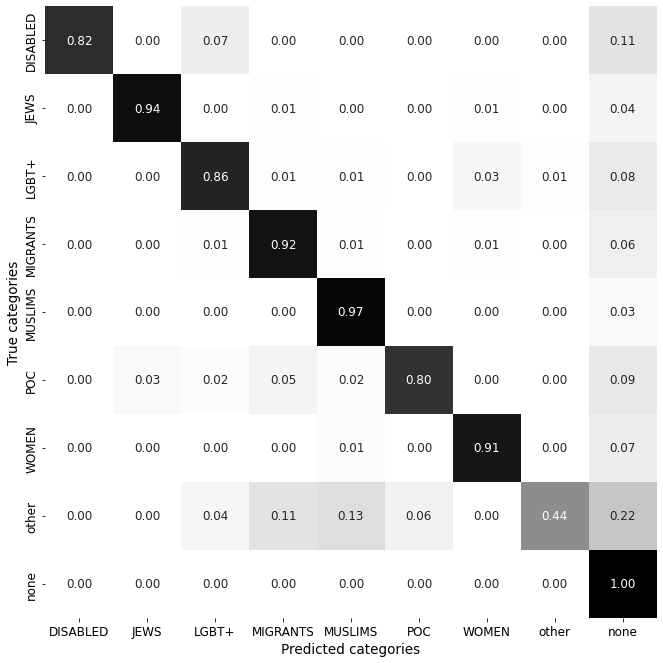

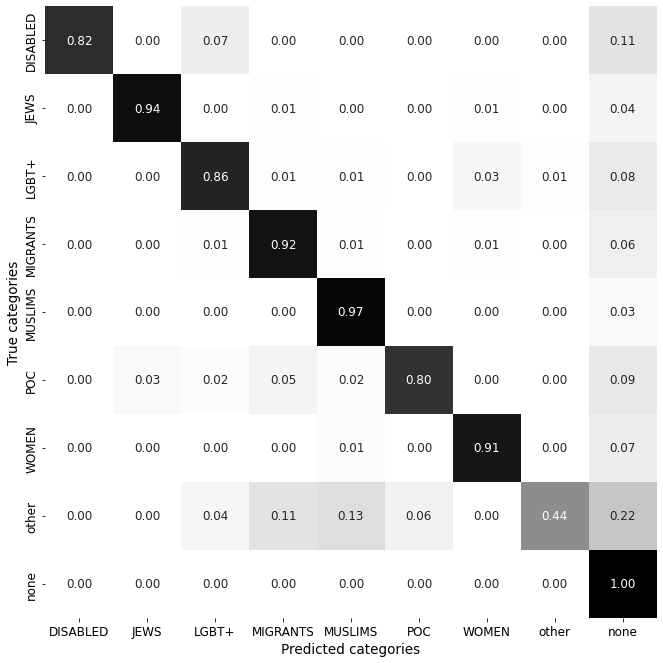

In [468]:
# X = docs
# y = combined_tar_list

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)
class_list = ['random_forest.pkl', 'svm.pkl']
class_model_list = ['random_forest_model.pkl, svm_model.pkl']

'''Load last updated classifier object''' 
new_clsf = Classifier(labels).load(infile = model_path + class_list[1])
print(new_clsf.get_model()) 

#OR 

'''Create new classifier object and pass it copy of last updated model''' 
sec_clsf = Classifier(labels) # labels, classifier = classifiers[1])                                                              
load_model = sec_clsf.load_model(infile = model_path + class_model_list[1])
print(load_model)

'''Two ways to load up and test models'''
y_preds = new_clsf.predict(X_test)
print(y_preds)

sec_y_preds = sec_clsf.predict(X_test)
print(sec_y_preds)

''' test model only ''' 
# md_y_preds = load_model.predict(X_test)
# print(md_y_preds)

# # new_clsf.set_params(model = load_model)

# # sec_y_preds.set_params(labels = labels, classifier = classifiers[1])

cls_report = new_clsf.classification_report(y_test, y_preds)
acc_report = new_clsf.accuracy_score(y_test, y_preds)
conf_m = new_clsf.confusion_matrix(y_test, y_preds)

new_clsf.report_results(y_test, y_preds)
new_clsf.heatmap()

cls_report = sec_clsf.classification_report(y_test, y_preds)
acc_report = sec_clsf.accuracy_score(y_test, y_preds)
conf_m = sec_clsf.confusion_matrix(y_test, y_preds)

sec_clsf.report_results(y_test, y_preds)
sec_clsf.heatmap()

# # look at set_model_params() with
# load_model.get_params().keys()

In [11]:
# LSTM and CNN *** sharfard paper 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

X = docs
y = combined_tar_list

min_max = MinMaxScaler()
standard_scale = StandardScaler()
# tfidf_X = tfidf_vectorizer.transform(X).toarray()
# tfidf_y = tfidf_vectorizer.transform(y).toarray()
# print(len(tfidf_X))
# print(len(tfidf_y))

tfidf_X = X
tfidf_y = y
X_ss = standard_scale.fit_transform(tfidf_X)
y_mm = min_max.fit_transform(tfidf_y) 
display(X_ss)
display(y_mm)

train_num = 0.8 * len(X)
# Must keep data in sequential order for memory learning 
X_train = X_ss[:train_num, :]
X_test = X_ss[train_num:, :]

y_train = y_mm[:train_num, :]
y_test = y_mm[train_num:, :]

max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen = max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen = max_review_length)

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

# from torch.autograd import Variable 
# X_train_tensors = Variable(torch.Tensor(X_train))
# X_test_tensors = Variable(torch.Tensor(X_test))

# y_train_tensors = Variable(torch.Tensor(y_train))
# y_test_tensors = Variable(torch.Tensor(y_test)) 

# X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
# X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

# lstm = torch.nn.LSTM(X) # 10, 20, 2)
# output, (hn, cn) = lstm(inputs, (h0, c0))

# create the model
embed_vec_length = 32
lstm = Sequential()
lstm.add(Embedding(train_num, embed_vec_length, input_length = max_review_length))
lstm.add(LSTM(100))
lstm.add(Dense(1, activation = 'sigmoid'))
lstm.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(lstm.summary())
lstm.fit(X_train, y_train, epochs = 3, batch_size = 64)

# print("Output:")
# print(output)
# print()
# print("hn:")
# print(hn)
# print()
# print("cn:")
# print(cn)
# lstm.compile(loss='cosine_proximity', optimizer='sgd', metrics = ['accuracy'])

# Final evaluation of the model
scores = lstm.evaluate(X_test, y_test, epochs = 1, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

In [21]:

nn_model = Sequential()
nn_model.add(Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
nn_model.add(GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
nn_model.add(SimpleRNN(128))

nn_model.add(Dense(10))

nn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 256)         247296    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In [50]:
X = docs
y = combined_tar_df

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)

y_preds = model.predict(X_test)

report = classification_report(y_test, y_preds)
print(report)
test_acc = accuracy_score(y_test, y_preds)
train_acc = lr.score(X_train, y_train) 

print('Logistic Regression Train accuracy {:.3f}%'.format(train_acc * 100)) 
print('Logistic Regression Test accuracy {:.3f}%'.format(test_acc * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')

# clsf_report = pd.DataFrame(classification_report(y_test, y_preds, output_dict = True)).transpose()
# clsf_report.to_csv(output_path + classifiers[0] + '_combined' + '.csv', index= True)

In [7]:
print(pd.Series(y_test))
print(pd.Series(y_preds))

414     3
1815    0
642     7
1056    2
4507    0
       ..
1623    3
2005    1
4174    3
3467    7
3475    6
Name: TARGET, Length: 1001, dtype: int64
0       3
1       0
2       6
3       2
4       0
       ..
996     3
997     1
998     3
999     7
1000    6
Length: 1001, dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.76      0.87        55
           1       0.99      0.95      0.97       128
           2       0.96      0.86      0.91       112
           3       0.93      0.97      0.95       186
           4       0.96      0.97      0.97       273
           5       0.94      0.77      0.85        79
           6       0.94      0.96      0.95       117
           7       1.00      0.59      0.74        59
           8       0.94      1.00      0.96       825

    accuracy                           0.95      1834
   macro avg       0.96      0.87      0.91      1834
weighted avg       0.95      0.95      0.94      1834

Random Forest Train accuracy 96.549%
Random Forest Test accuracy 94.656%
Confusion matrix: 
[[ 42   0   3   0   1   1   0   0   8]
 [  0 122   0   1   0   0   0   0   5]
 [  0   0  96   1   0   1   4   0  10]
 [  0   0   0 180   2   0   0   0   4]
 [  0   0   0   3 266   0   0   0   4]
 [  0   

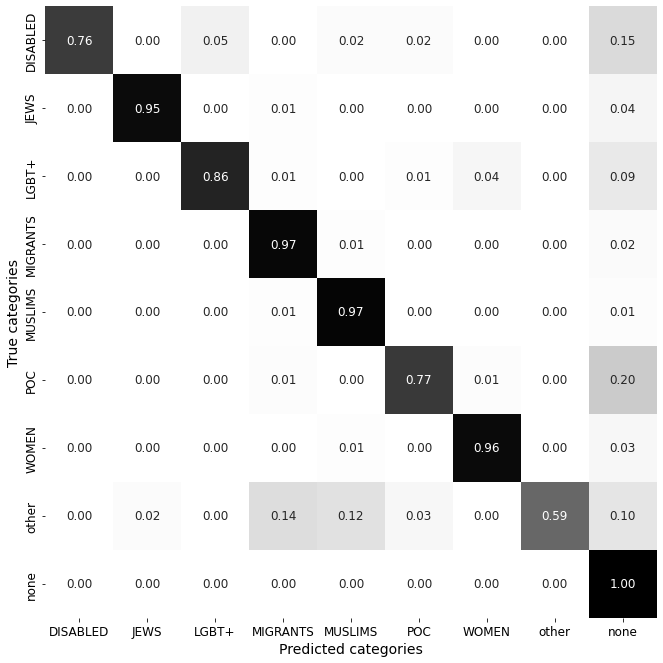

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)
report = classification_report(y_test, y_preds)
acc1 = accuracy_score(y_test, y_preds)
mod_train1 = rf.score(X_train, y_train) 

print(report)

print('Random Forest Train accuracy {:.3f}%'.format(mod_train1 * 100)) 
print('Random Forest Test accuracy {:.3f}%'.format(acc1 * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        55
           1       0.83      0.75      0.79       128
           2       0.87      0.81      0.84       112
           3       0.88      0.82      0.85       186
           4       0.78      0.75      0.77       273
           5       0.71      0.57      0.63        79
           6       0.94      0.80      0.87       117
           7       0.41      0.66      0.51        59
           8       0.93      0.98      0.95       825

    accuracy                           0.86      1834
   macro avg       0.80      0.77      0.78      1834
weighted avg       0.86      0.86      0.86      1834

Naive Bayes Train accuracy 96.549%
Naive Bayes Test accuracy 85.769%
Confusion matrix: 
[[ 44   0   4   0   2   0   0   0   5]
 [  0  96   2   5   7   2   0   7   9]
 [  1   4  91   0   8   2   2   0   4]
 [  0   0   2 152  13   2   0  14   3]
 [  0   3   0   6 206   5   0  32  21]
 [  0   5   

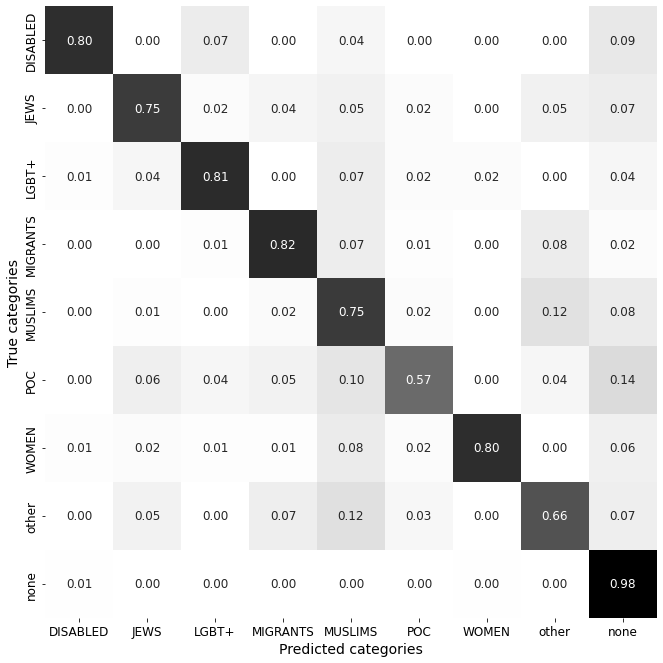

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), 
                                                    y, random_state=42, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train, y_train)
y_preds = nb.predict(X_test)
report = classification_report(y_test, y_preds)
acc2 = accuracy_score(y_test, y_preds)
mod_train2 = nb.score(X_train, y_train) 

print(report)

print('Naive Bayes Train accuracy {:.3f}%'.format(mod_train2 * 100)) 
print('Naive Bayes Test accuracy {:.3f}%'.format(acc2 * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')

              precision    recall  f1-score   support

           0       0.78      0.69      0.73        55
           1       0.97      0.97      0.97       128
           2       0.87      0.83      0.85       112
           3       0.86      0.95      0.91       186
           4       0.96      0.95      0.95       273
           5       0.91      0.80      0.85        79
           6       0.92      0.92      0.92       117
           7       0.64      0.61      0.63        59
           8       0.95      0.96      0.95       825

    accuracy                           0.92      1834
   macro avg       0.87      0.85      0.86      1834
weighted avg       0.92      0.92      0.92      1834

Decision Trees Train accuracy 96.549%
Decision Trees Test accuracy 91.876%
Confusion matrix: 
[[ 38   0   1   1   0   0   0   4  11]
 [  0 124   0   0   0   0   0   1   3]
 [  2   1  93   5   0   1   5   0   5]
 [  1   0   2 177   1   0   0   1   4]
 [  0   0   0   3 258   0   1   9   2]
 [  1 

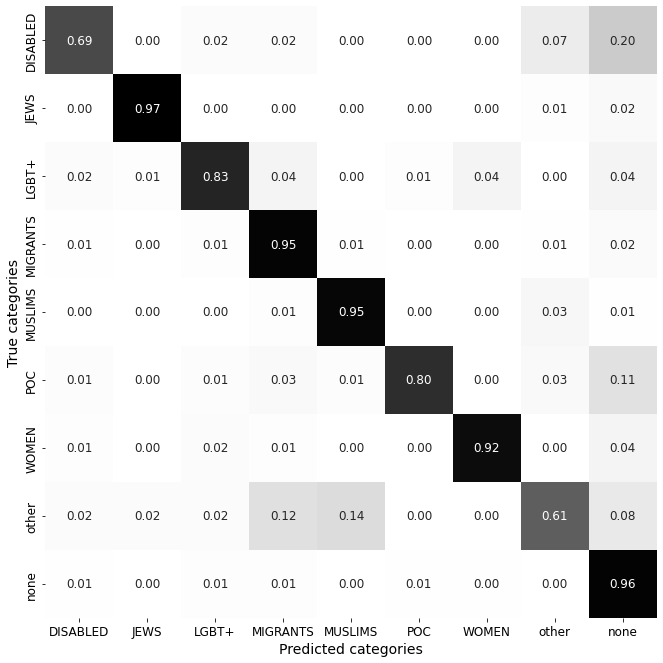

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)

y_preds = dt.predict(X_test)
report = classification_report(y_test, y_preds)
acc3 = accuracy_score(y_test, y_preds)
mod_train3 = dt.score(X_train, y_train) 

print(report)

print('Decision Trees Train accuracy {:.3f}%'.format(mod_train3 * 100)) 
print('Decision Trees Test accuracy {:.3f}%'.format(acc3 * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   8.1s
[CV] END .....................................C=0.1, gamma=1; total time=   7.9s
[CV] END .....................................C=0.1, gamma=1; total time=   8.0s
[CV] END .....................................C=0.1, gamma=1; total time=   8.0s
[CV] END .....................................C=0.1, gamma=1; total time=   7.9s
[CV] END ...................................C=0.1, gamma=0.1; total time=   6.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   7.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   6.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   6.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   7.3s
[CV] END ..................................C=0.1, gamma=0.01; total time=   6.7s
[CV] END ..................................C=0.1

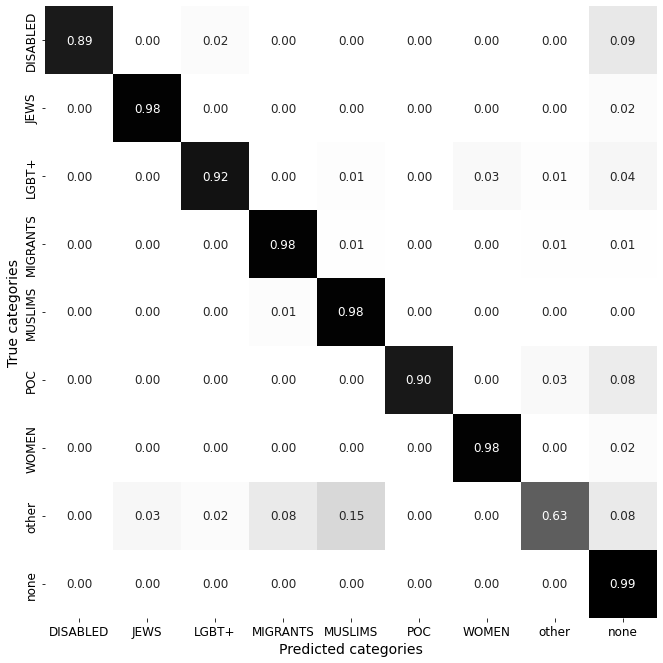

In [128]:
# considers params and gamma heavily with gaussian

# model selection and hyperparamter tuning step 
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1 , 0.1, 0.01, 0.001]} 
svm_grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)

svm_grid.fit(X_train, y_train)

y_preds = svm_grid.predict(X_test)
report = classification_report(y_test, y_preds)
acc4 = accuracy_score(y_test, y_preds)
mod_train4 = svm_grid.score(X_train, y_train) 

print(report)

print('SVM Train accuracy {:.3f}%'.format(mod_train4 * 100)) 
print('SVM Test accuracy {:.3f}%'.format(acc4 * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')


C:\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        55
           1       0.97      0.98      0.97       128
           2       0.99      0.94      0.96       112
           3       0.97      0.99      0.98       186
           4       0.96      0.99      0.97       273
           5       0.97      0.90      0.93        79
           6       0.97      0.98      0.98       117
           7       0.93      0.64      0.76        59
           8       0.97      0.99      0.98       825

    accuracy                           0.97      1834
   macro avg       0.97      0.92      0.94      1834
weighted avg       0.97      0.97      

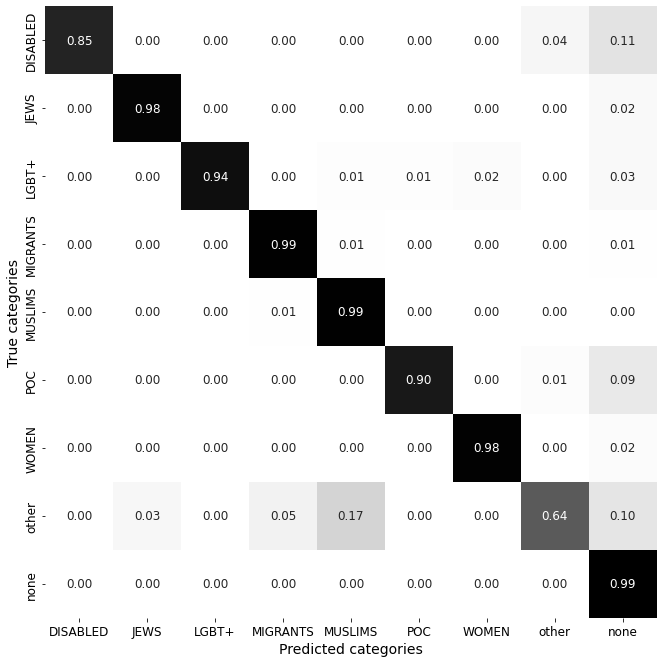

In [130]:
xg = XGBClassifier(random_state = 0)
xg.fit(X_train, y_train)

y_preds = xg.predict(X_test)
report = classification_report(y_test, y_preds)
acc4 = accuracy_score(y_test, y_preds)
mod_train4 = xg.score(X_train, y_train) 

print(report)

print('XG Trees Train accuracy {:.3f}%'.format(mod_train3 * 100)) 
print('XG Trees Test accuracy {:.3f}%'.format(acc3 * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')

In [85]:
# display(y)
# display(pd.Series(y_preds))